In [1]:
#
# phase2 :
#   Banana model inference
#
%matplotlib inline
import os
os.environ['THEANO_FLAGS'] = "mode=FAST_RUN,device=cpu,floatX=float32"
import theano
import theano.tensor as T
import config
import numpy as np
import matplotlib.pyplot as plt

/Library/Python/2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
import network
import network.normFlow as nf
import utils
import utils.mathT as mathT
import utils.mathZ as mathZ
import utils.theanoGeneral as utilsT
import utils.optimizers as optimizers
import utils.plotZ as plotZ
import models.mars as model
DIM = 2
SAMPLINGNUM = 20
floatX = utils.floatX

In [3]:
# parameter setup
valx = -3



In [ ]:
# constructing graphical model

OUTPATH = '../report/figs/loquat/'
# bnn
#mb = model.Banana()
#x = T.fscalar()
#mb.setX( x )
#mb.setStd(0.8)

# apple

# mb = model.Orange()
mb = model.Loquat()

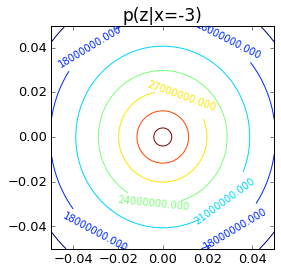

In [12]:
# plot true posterior
LOW,HIGH = -.05,+.05
GAP = 0.0002
gz, g1, g2 = mathZ.gridPoints( (LOW,HIGH,GAP), (LOW,HIGH,GAP) )
# bnn
# gpz = np.exp( mb.evalx_z(valx,gz).reshape(g1.shape[1],g2.shape[0]) )
# apple
gpz = np.exp( mb.evalx_z(gz).reshape(g1.shape[1],g2.shape[0]) )


fig = plt.figure()
CS = plt.contour(g1,g2,gpz)
plt.clabel(CS, inline=1, fontsize=10)
# plt.xlim(xlims); plt.ylim(ylims)
# lims = (-4,+4); plt.xlim(lims); plt.ylim(lims)
plt.axes().set_aspect('equal')
plt.tick_params(axis='both', which='major', labelsize=13)
plt.title('p(z|x=%d)' % (valx), fontsize=17)

plt.savefig(OUTPATH+'/bnn_x%d.png'%(valx))
plt.show()



In [4]:
NUM_LAYERS = 8

In [5]:
# construction variational model
iaf = nf.NormFlowModel( dim=DIM, numlayers=NUM_LAYERS,noisestd=1. )  #(4./DIM)**.5
e = iaf.getNoiseVar(SAMPLINGNUM)
z, logqz = iaf.reparam(e)

# setting cost variable
logpxz,_,_ = mb.logPxz(z)
cost = T.mean( logqz - logpxz )  # negative-ELBO

params = iaf.getParams()
grads = [ T.grad(cost,p,consider_constant=[e]) for p in params ]

In [6]:
# optimisation setup
iaf.reInit()
opt = optimizers.SGD(params,lr=0.05,momentum=0.5,decay=0.001)
updates = opt.getUpdates(params,grads)

outputs = [ cost, T.mean(logpxz), T.mean(logqz) ]
# bnn
# estep = theano.function(inputs=[x],outputs=outputs,updates=updates)
# apple
estep = theano.function(inputs=[],outputs=outputs,updates=updates)

In [7]:
# for presentation
e2 = iaf.getNoiseVar(50000)
z2, logqz2 = iaf.reparam(e2)
fez2 = theano.function(inputs=[],outputs=[e2,z2])

In [8]:
# training
NUMITER = 1000
keys = ['cost','pxz','qz']
record = {}

# mb.setStd(0.7)
for k in keys:
    record[k] = []
for i in range(NUMITER):
    # running updates
    # bnn
#     out = estep(valx)    
    # apple
    out = estep()
    for i,q in enumerate(out):
        record[keys[i]].append( q )        
for k in keys:
    record[k] = np.asarray( record[k] )

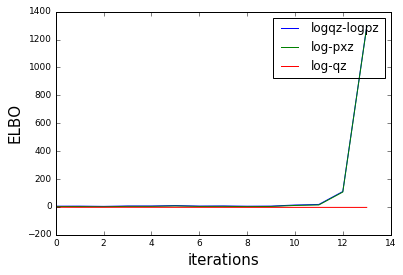

In [9]:
# plt.plot( range(NUMITER), record['cost'],'-' )
# plt.show()
xs = range(NUMITER)
plt.plot( xs, -record['cost'], '-', label='logqz-logpz')
plt.xlabel('iterations',fontsize=15)
plt.ylabel('ELBO',fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=9)
plt.savefig(OUTPATH+'/elbo_L%d_x%d.png'%(NUM_LAYERS,valx))

plt.plot( xs, record['pxz'], '-', label='log-pxz')
plt.plot( xs, record['qz'], '-', label='log-qz')

plt.legend()
plt.show()

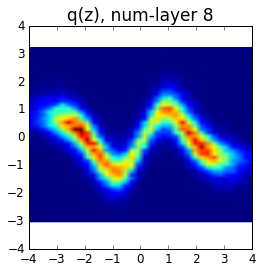

In [13]:
# estimated posterior
xlims = (-4,+4)
ylims = (-4,+4)
es, zs = fez2()
heatmap, xedges, yedges = np.histogram2d( zs[:,0], zs[:,1], bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.xlim(xlims)
plt.ylim(ylims)
plt.tick_params(axis='both', which='major', labelsize=12)
# bnn
# plt.title('q(z), num-layer %d, x=%d' % (NUM_LAYERS,valx), fontsize=17)
# apple
plt.title('q(z), num-layer %d' % (NUM_LAYERS), fontsize=17)
plt.savefig( OUTPATH+'/dist_L%d_x%d.png'%(NUM_LAYERS,valx))

In [8]:
gpz.shape
gpz[0,0]

4.9379065183537133e+238

(1000, 2) (1000, 2)


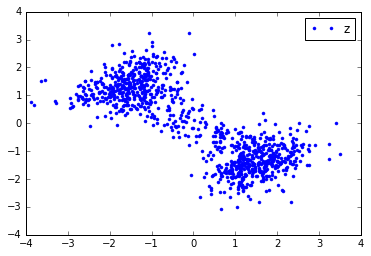

(1000, 2)
x=-3, z1*z2=-1.76284


In [9]:
es, zs = fez2()
print es.shape, zs.shape
# plt.plot(es[:,0],es[:,1],'.',label='e')
plt.plot(zs[:,0],zs[:,1],'.',label='z')
plt.legend(loc=1)
plt.show()
print zs.shape
print 'x=%s, z1*z2=%s' %( valx, np.mean(np.prod(zs,axis=1)) )